In [1]:
from tqdm import tqdm

from openff.recharge.conformers import ConformerGenerator, ConformerSettings
from openff.recharge.esp import ESPSettings
#from openff.recharge.esp.psi4 import Psi4ESPGenerator
from openff_psi4_debug import Psi4ESPGenerator
from openff.recharge.esp.storage import MoleculeESPRecord, MoleculeESPStore
from openff.recharge.grids import LatticeGridSettings
from openff.recharge.utilities.molecule import smiles_to_molecule
from openff.units.elements import SYMBOLS
from rdkit.Chem import AllChem
from openff.toolkit import Molecule

import os
import numpy as np
import random

In [3]:
#load our molecule to create the conformers

molecule = smiles_to_molecule("OCC(O)CO")
rdmol = molecule.to_rdkit()


In [4]:
AllChem.EmbedMultipleConfs(rdmol, numConfs=10, randomSeed=42)

In [3]:
from rdkit.Chem.rdForceFieldHelpers import MMFFOptimizeMolecule

In [6]:
#test the optimizer

optimize_MMFF = MMFFOptimizeMolecule(rdmol,mmffVariant = 'MMFF94',confId=3) #,confId=1,mmffvariant='MMFF94'
optimize_MMFF



0

In [7]:
#test all the conformers

for id in range(rdmol.GetNumConformers()):
    optimize_MMFF = MMFFOptimizeMolecule(rdmol,mmffVariant = 'MMFF94',confId=3) #,confId=1,mmffvariant='MMFF94'
    print(f'conformer:{id}, optimize (0 = converge, 1 = more iterations req): {optimize_MMFF}')

conformer:0, optimize (0 = converge, 1 = more iterations req): 0
conformer:1, optimize (0 = converge, 1 = more iterations req): 0
conformer:2, optimize (0 = converge, 1 = more iterations req): 0
conformer:3, optimize (0 = converge, 1 = more iterations req): 0
conformer:4, optimize (0 = converge, 1 = more iterations req): 0
conformer:5, optimize (0 = converge, 1 = more iterations req): 0
conformer:6, optimize (0 = converge, 1 = more iterations req): 0
conformer:7, optimize (0 = converge, 1 = more iterations req): 0
conformer:8, optimize (0 = converge, 1 = more iterations req): 0
conformer:9, optimize (0 = converge, 1 = more iterations req): 0


In [8]:
rdmol.GetConformer(1)

In [9]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol


In [10]:
#do the conformers look structurally sensible

for id in range(rdmol.GetNumConformers()):
    IPythonConsole.drawMol3D(rdmol,confId=id)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
optimize_MMFF

0

In [12]:
#now create a series of xyz files so we can run the conformers with ASE, first convert our conformers to xyz format and then write to file

from openff.units import unit

cwd = os.getcwd()

conformers = []



for confs in range(rdmol.GetNumConformers()):
    conformer = np.zeros((rdmol.GetConformer(confs).GetNumAtoms(), 3))
    for atom_index, coordinates in enumerate(rdmol.GetConformer(confs).GetPositions()):
        conformer[atom_index, :] = coordinates
    conformers.append(conformer * unit.angstrom)


for number ,conformer in enumerate(conformers):
    atoms = [
            {
                "element": SYMBOLS[atom.atomic_number],
                "x": conformer[index, 0],
                "y": conformer[index, 1],
                "z": conformer[index, 2],
            }
            for index, atom in enumerate(molecule.atoms)
        ]
    xyz = f'{molecule.n_atoms}\n{molecule.to_smiles()}\n'
    for row in atoms:
        xyz += f"{row['element']}\t{np.around(row['x'].magnitude,decimals=6)}\t{np.around(row['y'].magnitude,decimals=6)}\t{np.around(row['z'].magnitude, decimals=6)}\n"
    try:
        f = open(cwd+f"/conformer_{number}.xyz", 'x')
        f.write(xyz)
        f.close()
    except FileExistsError:
        continue

In [13]:
from ase.calculators.gaussian import Gaussian, GaussianOptimizer
import ase.io
from ase.visualize import view
!module load gaussian/09




/mnt/nfs/home/nca121/mambaforge/envs/openff/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/nfs/home/nca121/mambaforge/envs/openff/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/nfs/home/nca121/mambaforge/envs/openff/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/nfs/home/nca121/mambaforge/envs/openff/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [14]:
Gaussian.command = '/mnt/storage/apps/eb/software/gaussian/09/g09 < PREFIX.com > PREFIX.log'

In [15]:
test_atoms = ase.io.read('conformer_0.xyz')

In [16]:
view(test_atoms)

<Popen: returncode: None args: ['/mnt/nfs/home/nca121/mambaforge/envs/openff...>

In [17]:
calc_opt = Gaussian(label = 'conformer_0_opt',
                    method = 'hf',
                    basis = '6-31G*',
                    scf='qc'
                    )
opt = GaussianOptimizer(test_atoms, calc_opt)
opt.run(fmax='tight', steps=100)



No executable for file l1.exe.

Search path GAUSS_EXEDIR is ""
: No such file or directory
/bin/sh: line 1: 29642 Segmentation fault      /mnt/storage/apps/eb/software/gaussian/09/g09 < conformer_0_opt.com > conformer_0_opt.log


CalculationFailed: Calculator "gaussian" failed with command "/mnt/storage/apps/eb/software/gaussian/09/g09 < conformer_0_opt.com > conformer_0_opt.log" failed in /mnt/storage/nobackup/nca121/test_jobs/QM_ESP_Psi4/QM_ESP_Psi4 with error code 139

In [ ]:
from openff.recharge.utilities.molecule import smiles_to_molecule
from openff.recharge.conformers import ConformerGenerator, ConformerSettings
from openff.units.elements import SYMBOLS
import numpy as np
from openff.units import unit


In [ ]:
molecule = smiles_to_molecule("OCC(O)CO")
conformers = ConformerGenerator.generate(
    molecule, ConformerSettings(max_conformers=10)
)

In [ ]:
def conf_to_xyz_string(conformer, molecule):
    atoms = [
                    {
                        "element": SYMBOLS[atom.atomic_number],
                        "x": conformer[index, 0],
                        "y": conformer[index, 1],
                        "z": conformer[index, 2],
                    }
                    for index, atom in enumerate(molecule.atoms)
                ]
    xyz = f'{molecule.n_atoms}\n{molecule.to_smiles()}\n'
    for row in atoms:
        xyz += f"{row['element']}\t{np.around(row['x'].magnitude,decimals=6)}\t{np.around(row['y'].magnitude,decimals=6)}\t{np.around(row['z'].magnitude, decimals=6)}\n"
    return xyz

In [ ]:
conformers[0]

Magnitude,[[-0.3611847460269928 -0.008062569424510002 0.021483348682522774] [0.9523459672927856 0.5384629368782043 -0.032555222511291504] [1.1439802646636963 1.233094573020935 -1.3743836879730225] [2.4670777320861816 1.7732906341552734 -1.4064496755599976] [0.9855600595474243 0.2572946548461914 -2.534839153289795] [1.1710933446884155 0.9411581158638 -3.7698163986206055] [-0.45401597023010254 -0.4434690475463867 0.8860717415809631] [1.0573564767837524 1.2441487312316895 0.7981725335121155] [1.6660577058792114 -0.28194597363471985 0.09198283404111862] [0.4551912844181061 2.0798325538635254 -1.4719767570495605] [2.5237202644348145 2.3979244232177734 -0.6684095859527588] [-0.009874296374619007 -0.19747895002365112 -2.545755624771118] [1.7366387844085693 -0.5375308394432068 -2.487229347229004] [1.0608800649642944 0.2808915376663208 -4.472022533416748]]
Units,angstrom


In [ ]:
xyz_conf = conf_to_xyz_string(conformers[0],molecule)

In [ ]:
xyz_conf

'14\n[H]C([H])(C([H])(C([H])([H])O[H])O[H])O[H]\nO\t-0.361185\t-0.008063\t0.021483\nC\t0.952346\t0.538463\t-0.032555\nC\t1.14398\t1.233095\t-1.374384\nO\t2.467078\t1.773291\t-1.40645\nC\t0.98556\t0.257295\t-2.534839\nO\t1.171093\t0.941158\t-3.769816\nH\t-0.454016\t-0.443469\t0.886072\nH\t1.057356\t1.244149\t0.798173\nH\t1.666058\t-0.281946\t0.091983\nH\t0.455191\t2.079833\t-1.471977\nH\t2.52372\t2.397924\t-0.66841\nH\t-0.009874\t-0.197479\t-2.545756\nH\t1.736639\t-0.537531\t-2.487229\nH\t1.06088\t0.280892\t-4.472023\n'

In [ ]:
xyz_conf.split('\n')[0]

'14'

In [ ]:
xyz_conf.split('\n')[2:]#.split('\t')

['O\t-0.361185\t-0.008063\t0.021483',
 'C\t0.952346\t0.538463\t-0.032555',
 'C\t1.14398\t1.233095\t-1.374384',
 'O\t2.467078\t1.773291\t-1.40645',
 'C\t0.98556\t0.257295\t-2.534839',
 'O\t1.171093\t0.941158\t-3.769816',
 'H\t-0.454016\t-0.443469\t0.886072',
 'H\t1.057356\t1.244149\t0.798173',
 'H\t1.666058\t-0.281946\t0.091983',
 'H\t0.455191\t2.079833\t-1.471977',
 'H\t2.52372\t2.397924\t-0.66841',
 'H\t-0.009874\t-0.197479\t-2.545756',
 'H\t1.736639\t-0.537531\t-2.487229',
 'H\t1.06088\t0.280892\t-4.472023',
 '']

In [ ]:
xyz_conf.split('\n')

NameError: name 'xyz_conf' is not defined

In [ ]:
map(int,xyz_conf.split('\n')[2:][0].split('\t')[1:])


In [ ]:
list(map(float,xyz_conf.split('\n')[2:][0].split('\t')[1:]))


[-0.361185, -0.008063, 0.021483]

In [ ]:
xyz_conf.split('\n')[2:][1].split('\t')[1:]

['0.952346', '0.538463', '-0.032555']

In [1]:
molecule.n_conformers

NameError: name 'molecule' is not defined

In [ ]:
from openff.units import unit

conformer = np.zeros(3)
for atom_index, coordinates in enumerate(rdmol.GetConformer(confs).GetPositions()):
    conformer[atom_index, :] = coordinates
conformers.append(conformer * unit.angstrom)

NameError: name 'rdmol' is not defined

In [ ]:
conformer = np.zeros(shape=(int(xyz_conf.split('\n')[0]),3))

In [ ]:
xyz_conf

'14\n[H]C([H])(C([H])(C([H])([H])O[H])O[H])O[H]\nO\t-0.361185\t-0.008063\t0.021483\nC\t0.952346\t0.538463\t-0.032555\nC\t1.14398\t1.233095\t-1.374384\nO\t2.467078\t1.773291\t-1.40645\nC\t0.98556\t0.257295\t-2.534839\nO\t1.171093\t0.941158\t-3.769816\nH\t-0.454016\t-0.443469\t0.886072\nH\t1.057356\t1.244149\t0.798173\nH\t1.666058\t-0.281946\t0.091983\nH\t0.455191\t2.079833\t-1.471977\nH\t2.52372\t2.397924\t-0.66841\nH\t-0.009874\t-0.197479\t-2.545756\nH\t1.736639\t-0.537531\t-2.487229\nH\t1.06088\t0.280892\t-4.472023\n'

In [ ]:
conformer

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
for row in range(int(xyz_conf.split('\n')[0])+1):
    print(row)
    conformer[row, :] = list(map(float,xyz_conf.split('\n')[2:][row].split('\t')[:1]))

0


ValueError: could not convert string to float: 'O'

In [7]:
from openff.units import unit

cwd = os.getcwd()

conformers = []

molecule = smiles_to_molecule("OCC(O)CO")
rdmol = molecule.to_rdkit()
AllChem.EmbedMultipleConfs(rdmol, numConfs=10, randomSeed=42)

for confs in range(rdmol.GetNumConformers()):
    
    conformer = np.zeros((rdmol.GetConformer(confs).GetNumAtoms(), 3))
    for atom_index, coordinates in enumerate(rdmol.GetConformer(confs).GetPositions()):
        conformer[atom_index, :] = coordinates
    conformers.append(conformer * unit.angstrom)


In [8]:
[molecule.add_conformer(i) for i in conformers]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [9]:
molecule.n_conformers

10

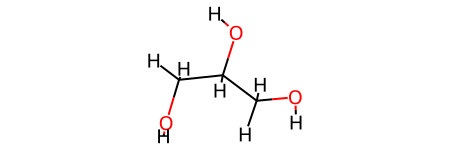

In [10]:
rdmol =  molecule.to_rdkit()

In [12]:
rdmol.GetNumConformers()

10

In [13]:
optimize_MMFF = MMFFOptimizeMolecule(rdmol,mmffVariant = 'MMFF94')

In [11]:
optimized_conformer = Molecule.from_rdkit(rdmol)

In [12]:
optimized_conformer.n_conformers


10

In [ ]:
np.zeros(3)

array([0., 0., 0.])

In [ ]:
np.array([row.split('\t') for row in xyz_conf.split('\n')[2:]][:-1])

array([['O', '-0.361185', '-0.008063', '0.021483'],
       ['C', '0.952346', '0.538463', '-0.032555'],
       ['C', '1.14398', '1.233095', '-1.374384'],
       ['O', '2.467078', '1.773291', '-1.40645'],
       ['C', '0.98556', '0.257295', '-2.534839'],
       ['O', '1.171093', '0.941158', '-3.769816'],
       ['H', '-0.454016', '-0.443469', '0.886072'],
       ['H', '1.057356', '1.244149', '0.798173'],
       ['H', '1.666058', '-0.281946', '0.091983'],
       ['H', '0.455191', '2.079833', '-1.471977'],
       ['H', '2.52372', '2.397924', '-0.66841'],
       ['H', '-0.009874', '-0.197479', '-2.545756'],
       ['H', '1.736639', '-0.537531', '-2.487229'],
       ['H', '1.06088', '0.280892', '-4.472023']], dtype='<U9')